# FOSM, data worth and related assessments

First Order Second Moment (FOSM), sometimes referred to as linear analysis, provides insights into the decision-support modelling process which are not possible to obtain in any other way. Outcomes are approximate. This is because relationships between groundwater model outputs and parameters are not in fact linear. 

Undertaking linear analysis requires:
 - A Jacobian matrix; 
 - The prior parameter covariance matrix;
 - The covariance matrix of measurement noise.

Linear analysis can be accomplished with software from the PEST utilities, PEST++GLM or pyEMU and can be performed before and/or after calibration. It relies on the existence of a Jacobian (sensitivity) matrix, whcih is calculated by PEST/PEST++ by perturbing parameters by a small amount from their initial value. This requires a single model run for each adjustable parameter and that the forecast of interest be included as an observation when filling the Jacobian. Prior parameter and measurement noise covariance matrices must be supplied by the user.

FOSM tasks may include:
 - approximate parameter and predictive uncertainty quantification;
 - data worth analysis;
 - assist in identifying parameters that are most salient for forecasts of interest, 
 - identify parameter contributions to predictive uncertainty and 
 - assess parameter identifiability. 

Visual outcomes of these analyses can provide easily understood insights into what history-matching can achieve, and what it cannot achieve due to lack of information. This can be used to streamline the data assimlation process and guide further site characterisation studies by ensuring effective data collection targeted at reducing the uncertainties of predictions that matter. 

Data worth analysis identifies relative observation contributions to reducing forecast uncertainty and is “forecast specific”. The value of each observation is compared in terms of its ability to reduce uncertainty of a unique forecast. Assessing data worth does not require that a measured value already be known. Thus it can be a useful tool when prioritizing what new data to collect. There are a few things to consider when including data worth set up as part of a modelling workflow:
 - any potential new data being assessed must be simulated by the model.
 - a Jacobian matrix must be calculated that links parameter changes to changes in the pontential new observation values. 
 
Thus, it is often useful to think about potential new data early on in the modelling workflow. This allows the modeller to pre-emptively include potential new observations in the PEST dataset with zeroweight (i.e. they do not affect history matching) for later use. 

### The current tutorial
 
In this notebook, we will use outputs from previous notebooks (in particular `freyberg_glm_1.ipynb`) to undertake data worth assessments based on first-order second-moment (FOSM) techniques. "Worth" is framed here in the context of the extent to which the uncertainty surrounding a model prediction of management interest is reduced through data collection.  Given that these anayses can help target and optimize data acquisition strategies, this is a concept that really resonates with decision makers.

Note that in this tutorial, we will demonstrate FOSM applied __before__ calibration (i.e. as an optional intermediate step between the `freyberg_glm_1.ipynb` and `freyberg_glm_2.ipynb` notebooks), as several of these techniques can be a usefull tools that aid in the design of the calibration setup. However, they are equaly applicable __after__ calibration. In the `freyberg_glm_2.ipynb` notebook, some outcomes of post-calibration FOSM are discussed. 

Here we will be using functionality in `pyemu` to undertake FOSM. Similar analyses can be undertaken with the PREDUNC and PREDVAR suite of PEST utilities (see the [GMDSI](https://gmdsi.org/education/tutorials/) website for tutorials on these utilities). 

### Admin

Start off with the usual loading of dependencies and preparing model and PEST files. We will be continuing to work with the MODFLOW6 modified-Freyberg model (see "freyberg intro to model" notebook), and the high-dimensional PEST dataset prepared in the "freyberg glm 1" notebook. For the purposes of this notebook, you do not require familiarity with previous notebooks (but it helps...). 

Simply run the next few cells by pressing `shift+enter`.

In [106]:
import os
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt;
import shutil 

import sys
sys.path.append(os.path.join("..", "..", "dependencies"))
import pyemu
import flopy

We are going to make use of the outcomes of the "freyberg_glm_1" tutorial, in which we ran `PEST++GLM` to calculate the jacobian matrix prior to calibration.

Let's start by specifying the folder path:

In [107]:
m_d = os.path.join("..","part2_4_glm","master_glm_1")

# a check to see if the files are avilable
if not os.path.exists(m_d):
    raise Exception("you need to run the '/part2_4_glm/freyberg_glm_1.ipynb' notebook")

OK, now let's read in our PEST control file and take a peek just to recall what is is we are working with:

In [108]:
pst = pyemu.Pst(os.path.join(m_d,"freyberg_pp.pst"))
print('adjustable parameters:',pst.npar_adj,'\nnonzero observations:', pst.nnz_obs)
#pst.write_par_summary_table(filename="none")

adjustable parameters: 415 
nonzero observations: 144


### Getting ready for FOSM

Recall we need three ingredients for FOSM:
 - parameter covariance matrix 
 - observation noise covariance matrix
 - jacobian matrix 

Let's start with the parameter covariance matrix. In this instance, our covariance matrix represents the prior parameter uncertainty. We preprared and recorded a prior covariance matrix when we constructed the PEST dataset (see the "pstfrom_pest_setup" tutorial). It is recorded in the file named `prior_cov.jcb`. 

Let's read it in a as a `pyemu.Cov` object:

In [109]:
# read the file
cov = pyemu.Cov.from_binary(os.path.join(m_d,"prior_cov.jcb")).to_dataframe()
# the prior was constructed for the high-dimensional dataset; 
# but we had to drop lots of parameters to undertake GLM (see "freyberg_glm_1" tutorial)
# so we need to slice cov to get only adjustable parameter cols/rows
cov = cov.loc[pst.adj_par_names,pst.adj_par_names]
# and then rebuild it
cov = pyemu.Cov.from_dataframe(cov)

Take a quick peek:

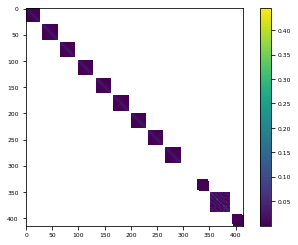

In [110]:
# let's inspect only
x = cov.x.copy()
x[x<1e-7] = np.nan
c = plt.imshow(x)
plt.colorbar()

The second ingredient we need is the jacobian matrix. In a previous tutorial, we ran `PEST++GLM` with the `fresyberg_pp.pst` control file to calculate the jacobian for intial parameter values and then stop (by setting `NOPTMAX` to -1). It is stored in the binary file named `freyberg_pp.jcb`.

Let's read it in as a `pyemu.Jco`:

In [111]:
jco_file = os.path.join(m_d,"freyberg_pp.jcb")

jco = pyemu.Jco.from_binary(jco_file)

Lastly, we are still missing the (diagonal) noise covariance matrix. Unless instructed otherwise, `pyemu` will construct this matrix on-the-fly using weights in the PEST control file (and assuming that weights are the inverse of the standard deviation). 

Alternatively you can provide a user created covariance matrix, such as the one constructed during the "obs and weights" tutorial. It is recorrded in the binary file named `obs_cov.jcb`. Let's load it in:

In [112]:
obscov = pyemu.Cov.from_binary(os.path.join(m_d,"obs_cov.jcb"))

The `Schur` object is one of the primary object for FOSM in pyEMU. It is the starting point for most things FOSM in the `pyemu` world. We are going to pass in our ingredients to instantiate a `Schur` object.

Now...`pyemu` is clever and does its best to reduce the amount of information you need to pass explicitly. Minimum requirements are the `Pst` and `Jco`. If not explicitly provided, the (diagonal) observation covariance matrix will be calculated from observation weights in `pst`. If present, forecasts will be populated from the list of `pst.forecast_names`.

However, here we will demonstrate by passing each ingredient explicitly:

In [113]:
sc = pyemu.Schur(pst=pst, # the pest control file
                jco=jco, # the jacobian matrix
                parcov=cov, # the parameter covariance matrix; if not provided pyemu calculates from parameter bounds
                obscov=obscov, # the obs noise cov matrix; necessary if obs weights in the pst do not reflect uncertainty
                forecasts=pst.forecast_names # forecast observation names
                )

sc

So that was easy...but maybe not the standard use case.  In many modeling analyses, there will be a separate scenario model - it is this model that will yield the forecast sensitivity vector(s) needed to map parameter uncertainty to forecast uncertainty.  That is, you will need to run the scenario model once for each parameter to fill a separate jacobian -  jacobian that has the same columns as the obervation jacobian, but has rows that are the forecasts.  

In these cases you would have a (1) jacobian that pertains to the history matching model, and (2) a jacobian that pertains to the scenario model. For the purposes of FOSM, you would be interested in the sensitivities of history-matching observations recorded in (1) and sensitivities of forecast observations recorded in (2).

Now we didnt do that here - our model forward run includes bth the history matching and scenario periods. But we can "fake" it just for the sake of demonstration. Let's pretend that we have a second jacobian calculated using a scenario model:


In [114]:
pretend_second_jco = pyemu.Jco.from_binary(jco_file)


Now we extract the forecast rows from the full jacobian:

In [115]:
forecast_jco = pretend_second_jco.get(row_names=pst.forecast_names, drop=True)

In [116]:
# shape: number of obs rows, number of par columns
forecast_jco.shape, jco.shape

((4, 415), (4623, 415))

In [117]:
sc = pyemu.Schur(pst=pst, # the pest control file
                jco=jco, # the jacobian matrix
                parcov=cov, # the parameter covariance matrix; if not provided pyemu calculates from parameter bounds
                obscov=obscov, # the obs noise cov matrix; necessary if obs weights in the pst do not reflect uncertainty
                forecasts=forecast_jco.T # forecast sensitivity vectors
                )

Boom - easy! 

All computations are done and contained within `sc`.  We can now access different parts of `sc`. 

### Posterior Parameter Uncertainty

Let's start by calculating the __posterior__ parameter covariance matrix. Here, we are updating parameter covariance following notional calibration as represented by te Jacobian matrix and both prior parameter and observation noise covariance matrices. 

In other words, given prior parameter uncertainty (expressed by the prior `cov` matrix) and the inherent noise in measurments (expressed by the `obscov` matrix), we calculate the expected parameter uncertainty __after__ calibration. This assumes that calibration achieves a fit comensurate with measurment noise, parameter linearity, etc.

The posterior parameter covariance is stored as a `pyemu.Cov` object in the `sc.posterior_parameter` attribute:

In [121]:
sc.posterior_parameter

In [122]:
sc.posterior_parameter.to_dataframe().sort_index(axis=1).iloc[100:105:,100:105]

,pname:nelayer3pp_inst:0_ptype:pp_pstyle:m_i:6_j:6_zone:1.0,pname:npfk33layer1cn_inst:0_ptype:cn_pstyle:m,pname:npfk33layer2cn_inst:0_ptype:cn_pstyle:m,pname:npfk33layer2pp_inst:0_ptype:pp_pstyle:m_i:10_j:10_zone:1.0,pname:npfk33layer2pp_inst:0_ptype:pp_pstyle:m_i:10_j:14_zone:1.0
pname:npfk33layer2pp_inst:0_ptype:pp_pstyle:m_i:2_j:14_zone:1.0,0.0,-0.001392,0.001375,0.000798,0.000660
pname:npfk33layer2pp_inst:0_ptype:pp_pstyle:m_i:6_j:2_zone:1.0,0.0,-0.000775,-0.000992,0.003010,0.000923
pname:npfk33layer2pp_inst:0_ptype:pp_pstyle:m_i:6_j:6_zone:1.0,0.0,-0.001345,-0.002043,0.007910,0.002073
pname:npfk33layer2pp_inst:0_ptype:pp_pstyle:m_i:6_j:10_zone:1.0,0.0,-0.002015,-0.001345,0.013269,0.004734
pname:npfk33layer2pp_inst:0_ptype:pp_pstyle:m_i:6_j:14_zone:1.0,0.0,-0.001615,0.000475,0.005822,0.007225


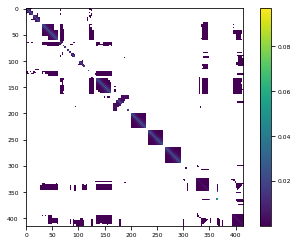

In [123]:
x = sc.posterior_parameter.x.copy()
x[x<1e-7] = np.nan
c = plt.imshow(x)
plt.colorbar(c)

In [124]:
par_sum = sc.get_parameter_summary().sort_values("percent_reduction",ascending=False)
par_sum

,prior_var,post_var,percent_reduction
pname:ghbheadcn_inst:0_ptype:cn_usecol:3_pstyle:a,0.444444,0.065931,8.516557e+01
pname:sfrcondcn_inst:0_ptype:cn_usecol:9_pstyle:m,0.111111,0.016790,8.488918e+01
pname:stosylayer1cn_inst:0_ptype:cn_pstyle:m,0.054284,0.009375,8.272986e+01
pname:npfklayer3cn_inst:0_ptype:cn_pstyle:m,0.054284,0.010556,8.055485e+01
pname:npfk33layer2pp_inst:0_ptype:pp_pstyle:m_i:30_j:14_zone:1.0,0.054284,0.020791,6.169962e+01
...,...,...,...
pname:nelayer2pp_inst:0_ptype:pp_pstyle:m_i:2_j:6_zone:1.0,0.054284,0.054284,-4.440892e-14
pname:nelayer3pp_inst:0_ptype:pp_pstyle:m_i:26_j:2_zone:1.0,0.054284,0.054284,-4.440892e-14
pname:nelayer2pp_inst:0_ptype:pp_pstyle:m_i:34_j:14_zone:1.0,0.054284,0.054284,-4.440892e-14
pname:nelayer1pp_inst:0_ptype:pp_pstyle:m_i:22_j:10_zone:1.0,0.054284,0.054284,-4.440892e-14


<AxesSubplot:>

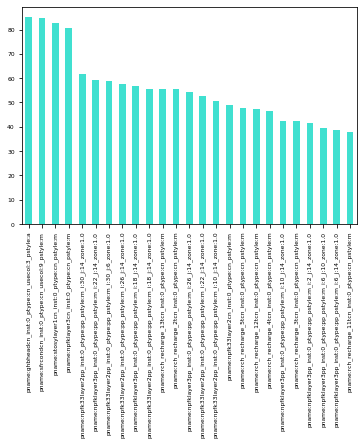

In [125]:
par_sum.loc[par_sum.index[:25],"percent_reduction"].plot(kind="bar",color="turquoise")

In [126]:
pst.nnz_obs_groups

['oname:hds_otype:lst_usecol:trgw-0-26-6',
 'oname:hds_otype:lst_usecol:trgw-0-3-8',
 'oname:hds_otype:lst_usecol:trgw-2-26-6',
 'oname:hds_otype:lst_usecol:trgw-2-3-8',
 'oname:sfr_otype:lst_usecol:gage-1',
 'oname:sfrtd_otype:lst_usecol:gage-1',
 'oname:hdstd_otype:lst_usecol:trgw-0-26-6',
 'oname:hdstd_otype:lst_usecol:trgw-0-3-8',
 'oname:hdstd_otype:lst_usecol:trgw-2-26-6',
 'oname:hdstd_otype:lst_usecol:trgw-2-3-8',
 'oname:hdsvd_otype:lst_usecol:trgw-0-26-6',
 'oname:hdsvd_otype:lst_usecol:trgw-0-3-8']

### Forecast Uncertainty

In [127]:
forecasts = sc.pst.forecast_names
forecasts

['oname:sfr_otype:lst_usecol:tailwater_time:4383.5',
 'oname:sfr_otype:lst_usecol:headwater_time:4383.5',
 'oname:hds_otype:lst_usecol:trgw-0-9-1_time:4383.5',
 'part_time']

In [128]:
df = sc.get_forecast_summary()
df

,prior_var,post_var,percent_reduction
oname:sfr_otype:lst_usecol:tailwater_time:4383.5,1.750545e+05,3.531209e+04,79.827947
oname:sfr_otype:lst_usecol:headwater_time:4383.5,8.510625e+04,2.821465e+04,66.847733
oname:hds_otype:lst_usecol:trgw-0-9-1_time:4383.5,2.466010e-01,4.349438e-02,82.362450
part_time,9.503174e+10,2.809681e+10,70.434289


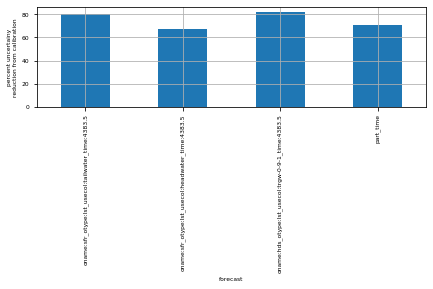

In [129]:
# make a pretty plot 
fig = plt.figure()
ax = plt.subplot(111)
ax = df["percent_reduction"].plot(kind='bar',ax=ax,grid=True)
ax.set_ylabel("percent uncertainy\nreduction from calibration")
ax.set_xlabel("forecast")
plt.tight_layout()

### Parameter contrib to uncert

In [130]:
par_contrib = sc.get_par_group_contribution()

In [131]:
par_contrib.head()

,oname:sfr_otype:lst_usecol:tailwater_time:4383.5,oname:sfr_otype:lst_usecol:headwater_time:4383.5,oname:hds_otype:lst_usecol:trgw-0-9-1_time:4383.5,part_time
base,35312.087582,28214.650069,0.043494,2.809681e+10
ghbcondcn,35271.309920,27787.246201,0.043099,2.805656e+10
ghbheadcn,28032.186100,27875.461017,0.041104,2.346110e+10
nelayer1cn,35312.087582,28214.650069,0.043494,2.809328e+10
nelayer1pp,35312.087582,28214.650069,0.043494,2.809447e+10


In [132]:
base = par_contrib.loc["base",:]
par_contrib = 100.0 * (base - par_contrib) / base
par_contrib.sort_index()

,oname:sfr_otype:lst_usecol:tailwater_time:4383.5,oname:sfr_otype:lst_usecol:headwater_time:4383.5,oname:hds_otype:lst_usecol:trgw-0-9-1_time:4383.5,part_time
base,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
ghbcondcn,1.154779e-01,1.514830e+00,9.090789e-01,0.143250
ghbheadcn,2.061589e+01,1.202174e+00,5.495609e+00,16.499051
nelayer1cn,2.060472e-14,-2.578787e-14,1.595354e-13,0.012557
nelayer1pp,2.060472e-14,-2.578787e-14,7.976770e-14,0.008343
nelayer2cn,2.060472e-14,-2.578787e-14,1.595354e-13,0.024953
nelayer2pp,2.060472e-14,-2.578787e-14,7.976770e-14,0.016578
nelayer3cn,2.060472e-14,-2.578787e-14,1.595354e-13,43.529753
nelayer3pp,2.060472e-14,-2.578787e-14,7.976770e-14,9.523375
npfk33layer1cn,2.151976e-01,5.662454e-01,4.723518e-01,0.000592


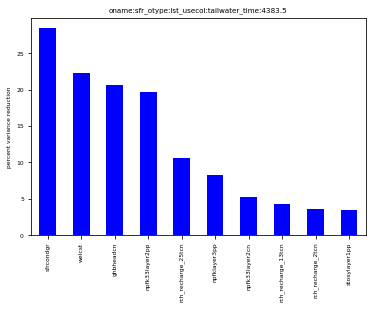

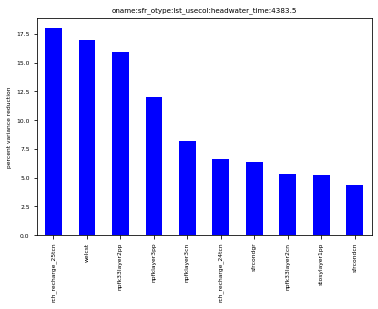

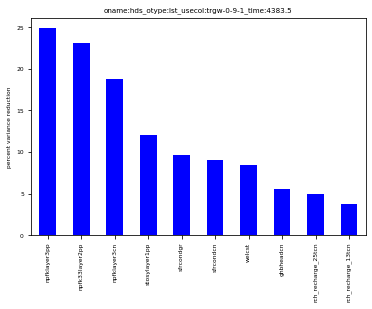

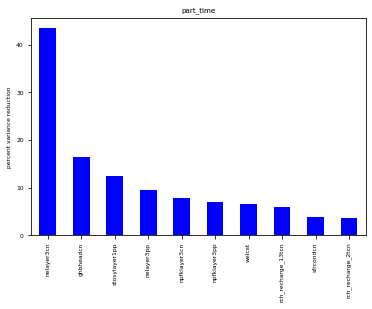

In [133]:
for forecast in par_contrib.columns:
    fore_df = par_contrib.loc[:,forecast].copy()
    fore_df.sort_values(inplace=True, ascending=False)
    ax = fore_df.iloc[:10].plot(kind="bar",color="b")
    ax.set_title(forecast)
    ax.set_ylabel("percent variance reduction")
    plt.show()

# Dataworth

In [134]:
sc.pst.nnz_obs_groups

['oname:hds_otype:lst_usecol:trgw-0-26-6',
 'oname:hds_otype:lst_usecol:trgw-0-3-8',
 'oname:hds_otype:lst_usecol:trgw-2-26-6',
 'oname:hds_otype:lst_usecol:trgw-2-3-8',
 'oname:sfr_otype:lst_usecol:gage-1',
 'oname:sfrtd_otype:lst_usecol:gage-1',
 'oname:hdstd_otype:lst_usecol:trgw-0-26-6',
 'oname:hdstd_otype:lst_usecol:trgw-0-3-8',
 'oname:hdstd_otype:lst_usecol:trgw-2-26-6',
 'oname:hdstd_otype:lst_usecol:trgw-2-3-8',
 'oname:hdsvd_otype:lst_usecol:trgw-0-26-6',
 'oname:hdsvd_otype:lst_usecol:trgw-0-3-8']

In [135]:
sc.get_obs_group_dict().keys()

dict_keys(['cum', 'hdslay1', 'hdslay2', 'hdslay3', 'inc', 'oname:cum_otype:lst_usecol:in-out', 'oname:cum_otype:lst_usecol:percent-discrepancy', 'oname:cum_otype:lst_usecol:rcha', 'oname:cum_otype:lst_usecol:sfr', 'oname:cum_otype:lst_usecol:sto-ss', 'oname:cum_otype:lst_usecol:sto-sy', 'oname:cum_otype:lst_usecol:total', 'oname:cum_otype:lst_usecol:wel', 'oname:hds_otype:lst_usecol:trgw-0-13-10', 'oname:hds_otype:lst_usecol:trgw-0-15-16', 'oname:hds_otype:lst_usecol:trgw-0-2-15', 'oname:hds_otype:lst_usecol:trgw-0-2-9', 'oname:hds_otype:lst_usecol:trgw-0-21-10', 'oname:hds_otype:lst_usecol:trgw-0-22-15', 'oname:hds_otype:lst_usecol:trgw-0-24-4', 'oname:hds_otype:lst_usecol:trgw-0-26-6', 'oname:hds_otype:lst_usecol:trgw-0-29-15', 'oname:hds_otype:lst_usecol:trgw-0-3-8', 'oname:hds_otype:lst_usecol:trgw-0-33-7', 'oname:hds_otype:lst_usecol:trgw-0-34-10', 'oname:hds_otype:lst_usecol:trgw-0-9-1', 'oname:hds_otype:lst_usecol:trgw-2-13-10', 'oname:hds_otype:lst_usecol:trgw-2-15-16', 'oname:

In [136]:
# breaks...pyemu prolem?

#dw_rm = sc.get_removed_obs_group_importance()
#dw_rm

In [137]:
# let's normalize to make more meaningful comparisons of data worth (unctainty variance reduction)
# base = dw_rm.loc["base",:]
# dw_rm = 100 * (dw_rm  - base) / base
# dw_rm.head()

In [138]:
#for forecast in dw_rm.columns:
#    fore_df = dw_rm.loc[:,forecast].copy()
#    fore_df.sort_values(inplace=True, ascending=False)
#    ax = fore_df.iloc[:10].plot(kind="bar",color="b")
#    ax.set_title(forecast)
#    ax.set_ylabel("percent variance increase")
#    plt.show()

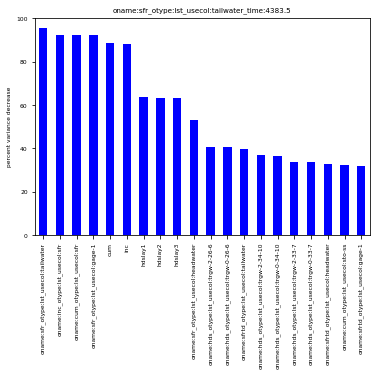

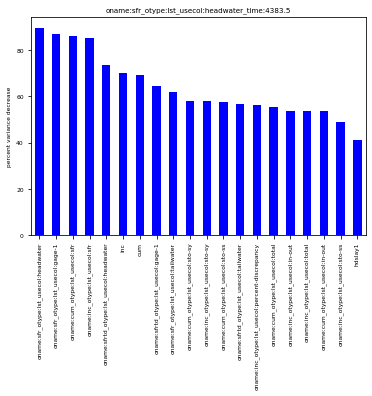

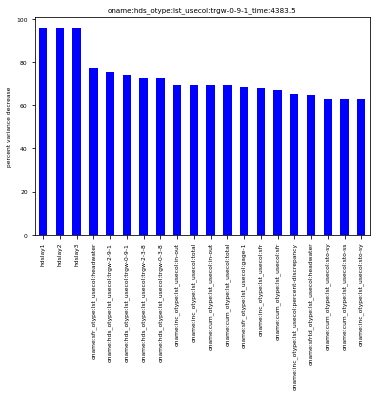

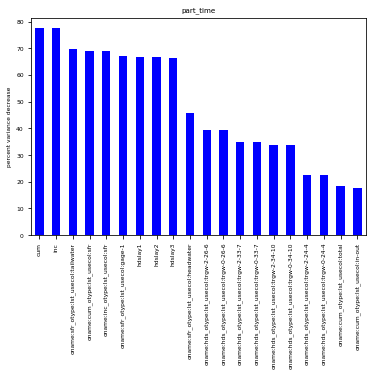

In [139]:
dw_ad = sc.get_added_obs_group_importance()
base = dw_ad.loc["base",:]
dw_ad = 100 * (base - dw_ad) / base
for forecast in dw_ad.columns:
    fore_df_ad = dw_ad.loc[:,forecast].copy()
    fore_df_ad.sort_values(inplace=True, ascending=False)
    ax = fore_df_ad.iloc[:20].plot(kind="bar",color="b")
    ax.set_title(forecast)
    ax.set_ylabel("percent variance decrease")
    plt.show()

Do these two approaches give the same answer? They shouldn't.. Why? Let's discuss..

### what is the worth of ${\it potential}$ observations? what data should we collect?

In [140]:
obs = sc.pst.observation_data
obs.oname.unique()

array(['hds', 'sfr', 'hdslay1', 'hdslay2', 'hdslay3', 'inc', 'cum',
       'sfrtd', 'hdstd', 'hdsvd', nan], dtype=object)

In [141]:
obs.time.astype(float).unique()[12]

4018.5

In [142]:
end_hist_time = obs.time.astype(float).unique()[12]
potential_obs = obs.loc[(obs.oname=='hds') & (obs.time.astype(float)<= end_hist_time), 'obsnme'].tolist()
len(potential_obs)

338

In [146]:
nz_obs = set(sc.pst.nnz_obs_names)
potential_obs = [o for o in potential_obs if o not in nz_obs]  


In [147]:
from datetime import datetime
start = datetime.now()
df_worth_new = sc.get_added_obs_importance(obslist_dict=potential_obs, base_obslist=sc.pst.nnz_obs_names, reset_zero_weight=True)
print("took:",datetime.now() - start)

took: 0:00:17.264711


In [ ]:
df_worth_new.head()

,oname:sfr_otype:lst_usecol:tailwater_time:4383.5,oname:sfr_otype:lst_usecol:headwater_time:4383.5,oname:hds_otype:lst_usecol:trgw-0-9-1_time:4383.5,part_time
base,35312.087582,28214.650069,0.043494,2.809681e+10
oname:hds_otype:lst_usecol:trgw-0-13-10_time:3652.5,35299.940107,28203.814419,0.043481,2.808638e+10
oname:hds_otype:lst_usecol:trgw-0-13-10_time:3683.5,35306.282621,28203.935073,0.043480,2.808441e+10
oname:hds_otype:lst_usecol:trgw-0-13-10_time:3712.5,35308.241394,28202.682338,0.043477,2.808269e+10
oname:hds_otype:lst_usecol:trgw-0-13-10_time:3743.5,35310.541352,28204.727050,0.043479,2.807984e+10


### an "extra" if we have time: parameter identifiability

In [152]:
la = pyemu.ErrVar(jco=jco)

In [153]:
s = la.qhalfx.s  # singular spectrum
s.x[:10]

array([[327.38847516],
       [175.29894786],
       [133.48727953],
       [ 90.85453325],
       [ 58.58701751],
       [ 49.37343145],
       [ 45.26632341],
       [ 35.9999825 ],
       [ 32.74751414],
       [ 28.43588565]])

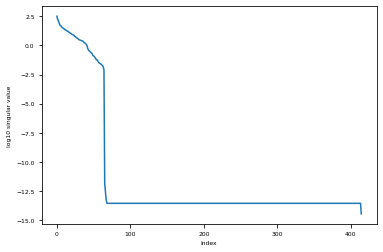

In [154]:
figure = plt.figure()
ax = plt.subplot(111)
ax.plot(np.log10(s.x))
ax.set_ylabel("log10 singular value")
ax.set_xlabel("index")
#ax.set_xlim(0,100)
plt.show()

In [155]:
truncation_thresh = 5e-5
n_signif_singvals = ((s.x / s[0].x) > truncation_thresh).sum()
n_signif_singvals

63

In [156]:
print("This means that, on the basis of the {0} (non-zero) weighted observations, \
there are {1} unique pieces of information in the calibration dataset.  \
Recall the inverse problem we are trying to solve involves the estimation of {2} parameters using this information only...".\
      format(la.pst.nnz_obs, n_signif_singvals, pst.npar_adj))

This means that, on the basis of the 144 (non-zero) weighted observations, there are 63 unique pieces of information in the calibration dataset.  Recall the inverse problem we are trying to solve involves the estimation of 415 parameters using this information only...


In [157]:
ident_df = la.get_identifiability_dataframe(4)  # sing val trunc defaults to pst.nnz_obs

<AxesSubplot:>

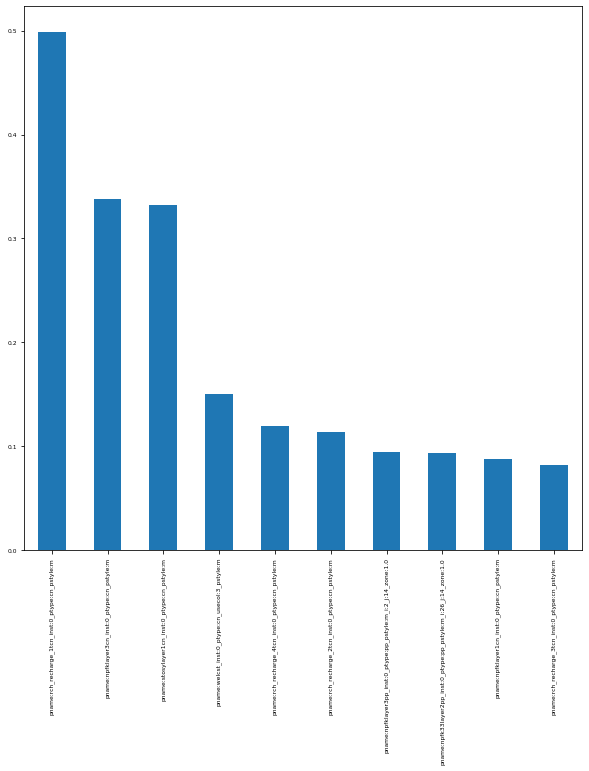

In [158]:
ident_df.sort_values(by="ident",ascending=False).iloc[0:10].loc[:,"ident"].plot(kind="bar",figsize=(10,10))

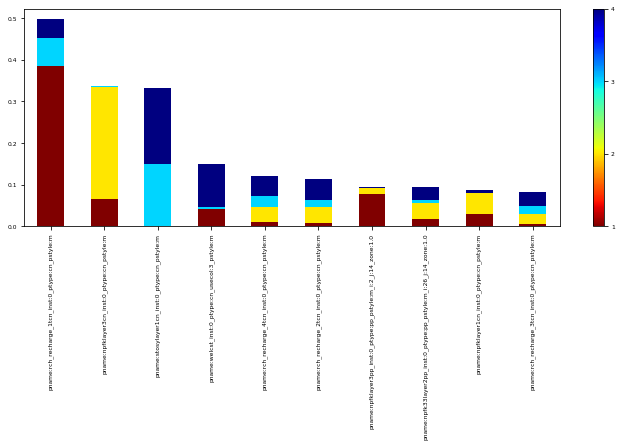

In [159]:
id = pyemu.plot_utils.plot_id_bar(ident_df.sort_values(by="ident",ascending=False).iloc[0:10], figsize=(12,4))

In [164]:
?la.get_par_css_dataframe

Signature: la.get_par_css_dataframe()
Docstring:
get a dataframe of composite scaled sensitivities.  Includes both
PEST-style and Hill-style.

Returns:
    `pandas.DataFrame`: a dataframe of parameter names, PEST-style and
    Hill-style composite scaled sensitivity
File:      c:\users\rui2h\.conda\envs\gmdsitut\lib\site-packages\pyemu\la.py
Type:      method


In [160]:
css = la.get_par_css_dataframe()
css.head()

,pest_css,hill_css
pname:npfklayer1pp_inst:0_ptype:pp_pstyle:m_i:2_j:2_zone:1.0,0.024189,0.0
pname:npfklayer1pp_inst:0_ptype:pp_pstyle:m_i:2_j:7_zone:1.0,0.014456,0.0
pname:npfklayer1pp_inst:0_ptype:pp_pstyle:m_i:2_j:12_zone:1.0,0.006046,0.0
pname:npfklayer1pp_inst:0_ptype:pp_pstyle:m_i:2_j:17_zone:1.0,0.022869,0.0
pname:npfklayer1pp_inst:0_ptype:pp_pstyle:m_i:7_j:2_zone:1.0,0.014872,0.0


In [161]:
css = css.sort_values(by="pest_css",ascending=False)
css = css.loc[css.pest_css==0.0,:]
len([p for p in css.index if "sy" in p])

0

In [163]:
css

,pest_css,hill_css
pname:rch_recharge_19tcn_inst:0_ptype:cn_pstyle:m,0.0,0.0
pname:rch_recharge_23tcn_inst:0_ptype:cn_pstyle:m,0.0,0.0
pname:rch_recharge_24tcn_inst:0_ptype:cn_pstyle:m,0.0,0.0
pname:rch_recharge_20tcn_inst:0_ptype:cn_pstyle:m,0.0,0.0
pname:rch_recharge_22tcn_inst:0_ptype:cn_pstyle:m,0.0,0.0
...,...,...
pname:nelayer3pp_inst:0_ptype:pp_pstyle:m_i:6_j:2_zone:1.0,0.0,0.0
pname:nelayer3pp_inst:0_ptype:pp_pstyle:m_i:6_j:6_zone:1.0,0.0,0.0
pname:nelayer3pp_inst:0_ptype:pp_pstyle:m_i:6_j:10_zone:1.0,0.0,0.0
pname:nelayer3pp_inst:0_ptype:pp_pstyle:m_i:6_j:14_zone:1.0,0.0,0.0


In [162]:
par = pst.parameter_data.loc[pst.adj_par_names]
par.loc[par.parnme.apply(lambda x: "sy" in x),:].shape

(33, 23)